In [1]:
#svm_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#5 July 2018
#
#train an svm model on the XO dataset, this executes in 30? minutes on m4.xlarge instance

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate smallish sample training data...so that model hyperparameters can be tuned quickly
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,1.570916,7.002963,7.176996,1.350128,B,0.0,0.0,1.0
19996,19996,3.771158,6.676721,7.668131,1.056645,B,0.0,0.0,1.0
19997,19997,-5.743447,3.750622,6.859617,2.563093,B,0.0,0.0,1.0
19998,19998,-4.096441,-3.755208,5.557195,-2.399627,B,0.0,0.0,1.0
19999,19999,-2.282053,-3.327819,4.035114,-2.171895,O,0.0,1.0,0.0


In [5]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

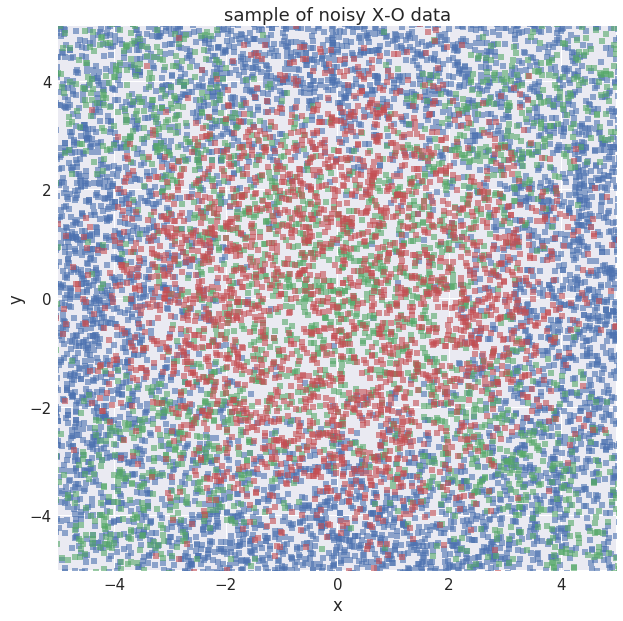

In [6]:
#scatterplot of noisy training data
df = train
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/training_data.png')

In [7]:
#check class balance
cols = ['id', 'class']
N = train[cols].groupby('class').count().sort_values('id')
N

,id
class,
O,2559
X,2744
B,14697


In [8]:
#rebalance training data
idx_O = (train['class'] == 'O')
idx_X = (train['class'] == 'X')
idx_B = (train['class'] == 'B')
train_balanced = train[idx_O].append(train[idx_X]).append(train[idx_B].sample(n=idx_O.sum()))
train_balanced[cols].groupby('class').count()

,id
class,
B,2559
O,2559
X,2744


In [9]:
#get features x and target variable y
x_cols = ['x', 'y']
y_col = 'class'
x = train_balanced[x_cols]
y = train_balanced[y_col]

In [10]:
#grid-search across hyperparameters, executed in parallel on all available cpus (4 cpus on m4.xlarge)
#this takes several minutes, and executes more slowly for gamma>>1
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True)
from sklearn.model_selection import GridSearchCV
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]
gammas = [0.001, 0.01, 0.1, 1.0, 10.0]
hperparameters = {'C':Cs, 'gamma':gammas}
model_grid = GridSearchCV(model, hperparameters, verbose=-1, n_jobs=-1).fit(x, y) #set verbose=2 when debugging

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.001, gamma=0.01 .............................................
[CV] C=0.001, gamma=0.01 .............................................
[CV] C=0.001, gamma=0.1 ..............................................
[CV] C=0.001, gamma=0.01 .............................................
[CV] ............................... C=0.001, gamma=0.1, total=  14.4s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .............................. C=0.001, gamma=0.01, total=  14.9s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .............................. C=0.001, gamma=0.01, total=  15.0s
[CV] C=0.001, gamma=1.0 ..............................................
[CV] .............................. C=0.001, gamma=0.01, total=  15.1s
[CV] C=0.001, gamma=1.0 ..............................................
[CV] ............................... C=0.001, gamma=0.1, total=  13.9s
[CV] C=0.001, ga

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min


[CV] ................................. C=0.1, gamma=0.1, total=   7.9s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ................................ C=0.1, gamma=0.01, total=  10.8s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   8.8s
[CV] C=0.1, gamma=3.0 ................................................
[CV] ................................. C=0.1, gamma=1.0, total=  12.6s
[CV] C=0.1, gamma=3.0 ................................................
[CV] ................................. C=0.1, gamma=1.0, total=  13.1s
[CV] C=0.1, gamma=3.0 ................................................
[CV] ................................. C=0.1, gamma=1.0, total=  13.0s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................................. C=0.1, gamma=3.0, total=  16.4s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.1min finished


In [11]:
#GridSearchCV's recommended model and hyperparameters
best_params_ = model_grid.best_params_
C = best_params_['C']
gamma =  best_params_['gamma']
best_score = model_grid.best_score_
print best_score
print best_params_
print C, gamma
#model_grid.cv_results_

0.6689137624014245
{'C': 1.0, 'gamma': 0.1}
1.0 0.1


In [12]:
#now train SVC model on x10 larger dataset
N_dots *= 10
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
print train.shape
idx_O = (train['class'] == 'O')
idx_X = (train['class'] == 'X')
idx_B = (train['class'] == 'B')
train_balanced = train[idx_O].append(train[idx_X]).append(train[idx_B].sample(n=idx_O.sum()))
print train_balanced[cols].groupby('class').count()
x = train_balanced[x_cols]
y = train_balanced[y_col]
model = SVC(kernel='rbf', C=C, gamma=gamma, probability=True).fit(x, y)

(200000, 9)
          id
class       
B      25654
O      25654
X      27101


In [13]:
#generate predictions on testing dataset
N_dots = 20000
test = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = test[x_cols]
test['class_pred'] = model.predict(x)
test.head()

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,-3.092237,-0.193902,3.098310,-3.078968,O,0.0,1.0,0.0,O
1,1,-3.764819,3.806028,5.353476,2.350751,X,1.0,0.0,0.0,X
2,2,0.643327,-0.551272,0.847214,-0.708491,O,0.0,1.0,0.0,X
3,3,5.223371,-0.372952,5.236669,-0.071280,B,0.0,0.0,1.0,B
4,4,9.071897,0.561268,9.089243,0.061790,B,0.0,0.0,1.0,B


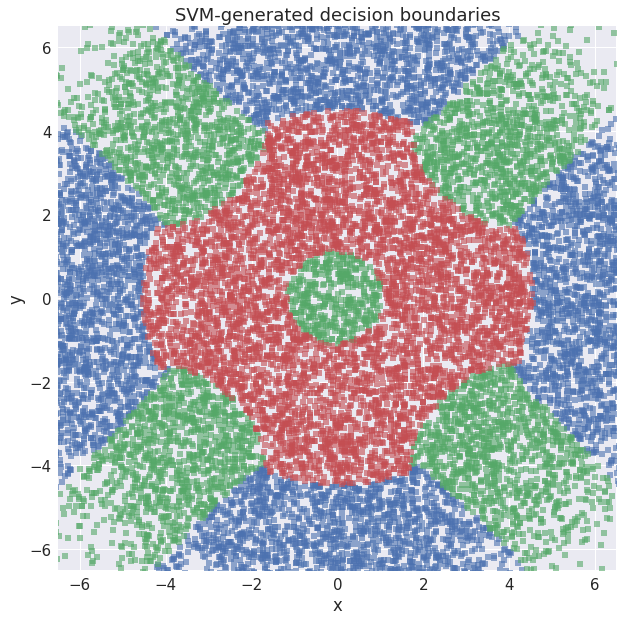

In [14]:
#scatterplot showing model's predicted decision boundaries
df = test
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('SVM-generated decision boundaries')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/svm_decision_boundary.png')

In [15]:
#model accuracy
idx = (test['class'] == test['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.6792


In [16]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  26.034851567
